**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Deep learning for Bulldozers

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

# Load in our data from last lesson

In [3]:
dep = 'SalePrice'
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/bulldozers-raw')

np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

keep_cols = list(np.load('tmp/keep_cols.npy'))
np.load = np_load_old

In [4]:
df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid

In [5]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

'YearMade Coupler_System ProductSize fiProductClassDesc ModelID saleElapsed Hydraulics_Flow fiSecondaryDesc Enclosure fiModelDesc fiModelDescriptor ProductGroup Tire_Size Hydraulics Track_Type saleDay state saleDayofyear Drive_System age'

In [6]:
for o in ['saleElapsed', 'saleDayofyear', 'saleDay', 'age', 'YearMade']: cat_flds.remove(o)
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

[]

In [7]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds]
' '.join(cont_flds)

'YearMade saleElapsed SalesID MachineID saleDay saleDayofyear age'

In [8]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, nas, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))

In [9]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)

In [10]:
df.head()

,Coupler_System,ProductSize,fiProductClassDesc,ModelID,Hydraulics_Flow,fiSecondaryDesc,Enclosure,fiModelDesc,fiModelDescriptor,ProductGroup,...,Track_Type,state,Drive_System,YearMade,saleElapsed,SalesID,MachineID,saleDay,saleDayofyear,age
0,0,0,59,644,0,41,3,950,0,6,...,0,1,0,0.913196,0.397377,-0.858580,-0.496185,-0.013101,1.352092,-0.828814
1,0,4,62,11,0,55,3,1725,0,6,...,0,33,0,0.405756,-0.061496,-0.858578,-2.494936,1.173518,-0.907472,-0.430749
2,1,0,39,1542,3,0,6,331,0,3,...,0,32,0,0.722906,-0.075286,-0.858577,-1.775759,1.173518,-1.187503,-0.762470
3,0,6,8,110,0,0,3,3674,0,4,...,0,44,0,0.722906,1.179600,-0.858574,-0.434096,0.342885,-0.395690,-0.298060
4,1,0,40,3540,3,0,1,4208,0,3,...,0,32,0,1.103486,0.863382,-0.858572,-0.364020,0.817532,0.231967,-0.828814


# Model

In [11]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [12]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'Coupler_System': 3,
 'ProductSize': 7,
 'fiProductClassDesc': 75,
 'ModelID': 5219,
 'Hydraulics_Flow': 4,
 'fiSecondaryDesc': 176,
 'Enclosure': 7,
 'fiModelDesc': 5000,
 'fiModelDescriptor': 140,
 'ProductGroup': 7,
 'Tire_Size': 18,
 'Hydraulics': 13,
 'Track_Type': 3,
 'state': 54,
 'Drive_System': 5}

In [13]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]
metrics=[rmse]

In [14]:
y_range=(0,np.max(y)*1.2)

In [15]:
m = md.get_learner(emb_szs, len(cont_flds), 0.05, 1, [500,250], [0.5,0.05],
                   y_range=y_range, use_bn=True)

In [16]:
m.lr_find()

  0%|                                                                                         | 0/6081 [00:00<?, ?it/s]

C:\Users\sv725e\.conda\envs\fastai\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 61%|████████████████████████████████████████▌                         | 3732/6081 [01:33<00:55, 42.22it/s, loss=0.275]

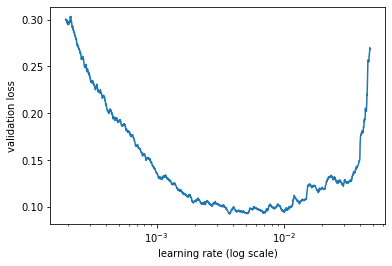

In [17]:
m.sched.plot(1300)

In [18]:
lr=1e-3; wd=1e-7

In [19]:
m.fit(lr, 2, wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.065128   0.245429  
    1      0.059041   0.094197                                                                                         
    2      0.052847   0.093798                                                                                         


[0.0937980569601059]

In [ ]:
m.fit(lr, 2, wd, cycle_len=2, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.05349    0.101157  
 56%|████████████████████████████████████▋                            | 3431/6081 [01:49<01:26, 30.73it/s, loss=0.0488]

In [ ]:
math.sqrt(0.0487)